# MonaLIA Pair-Wise Odds Ratio between categories 

In [1]:
from __future__ import print_function

import os
import sys

import numpy as np
import pandas as pd

import SPARQLWrapper

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm
from sklearn import metrics

from IPython.display import display, HTML
from  textwrap import wrap

In [2]:
# Import MonaLIA library from the package in the subfolder of the notebook folder
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib 
from MonaLIA.util import metadata_helpers as metadata
from MonaLIA.util import visualization_helpers as vis_helpers


importlib.reload(metadata)
importlib.reload(vis_helpers)

<module 'MonaLIA.util.visualization_helpers' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\MonaLIA\\util\\visualization_helpers.py'>

In [3]:
print('SPARQLWrapper ver.', SPARQLWrapper.__version__)
print('Pandas ver.', pd.__version__)

SPARQLWrapper ver. 1.8.5
Pandas ver. 1.0.1


In [4]:
wds_Joconde_Corese = 'http://localhost:8080/sparql'

## Query annotations

In [5]:
query_annotations = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select 
        ?notice
        ?noticeReference
        (group_concat(distinct ?topCategory_label; separator="+") as ?target_labels)
		(group_concat(distinct ?subCategory_label;  separator="+") as ?actual_labels)
        (sample(?noticeRepresentation) as ?repr)
where { 

       { 
            select (?classifierClass_label as ?topCategory_label )
            where 
              {
                ?classifierType ml:vocabID "REPR" .
                ?classifier rdfs:subClassOf ?classifierType.
                ?classifier rdfs:label "40_classes". #?classifierName.
                ?classifier ml:conatainsClass [a ?classifierClass; skos:prefLabel ?classifierClass_label]

                #filter (?classifierClass_label = "chien"@fr)
              }
        }
                  

        ?topCategory a jcl:Term;
               skos:prefLabel ?topCategory_label;
               skos:narrower* ?subCategory.

        ?subCategory  skos:prefLabel ?subCategory_label.

        ?notice jcl:noticeReprTerm ?subCategory;
                jcl:noticeHasImage true;               
                jcl:noticeRef ?noticeReference.
                
        optional {
            ?notice jcl:noticeRepr ?noticeRepresentation.
        }  
            
                    
}
group by ?notice 
#order by ?notice ?topCategory_label
'''

In [6]:
%time annotations_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_annotations)
print(annotations_df.shape)

Wall time: 1min 46s
(97467, 5)


In [8]:
def my_tokenizer(s):
    return list(filter(None, set(s.split('+'))))

annotations_df.target_labels = annotations_df.target_labels.apply(my_tokenizer)

In [12]:
annotations_df.head()

,notice,noticeReference,target_labels,actual_labels,repr
0,https://jocondelab.iri-research.org/data/notic...,00000055013,"[draperie, oiseau]",draperie+chardonneret,"figures bibliques (Vierge à l'Enfant, chardonn..."
1,https://jocondelab.iri-research.org/data/notic...,00000055015,[livre],livre,"nature morte (crâne, sphère : la terre, violon..."
2,https://jocondelab.iri-research.org/data/notic...,00000055022,[chien],chien,"scène (couple, famille, paysan, vêtement, chie..."
3,https://jocondelab.iri-research.org/data/notic...,00000055025,[chapeau],chapeau,"portrait (La Fayette marquis de, debout, habit..."
4,https://jocondelab.iri-research.org/data/notic...,00000055028,[arbre],feuillu,"paysage (chemin, effet de soleil, feuillu, per..."


## Create indicators columns

In [13]:
annotations_df.explode('target_labels').head()

,notice,noticeReference,target_labels,actual_labels,repr
0,https://jocondelab.iri-research.org/data/notic...,00000055013,draperie,draperie+chardonneret,"figures bibliques (Vierge à l'Enfant, chardonn..."
0,https://jocondelab.iri-research.org/data/notic...,00000055013,oiseau,draperie+chardonneret,"figures bibliques (Vierge à l'Enfant, chardonn..."
1,https://jocondelab.iri-research.org/data/notic...,00000055015,livre,livre,"nature morte (crâne, sphère : la terre, violon..."
2,https://jocondelab.iri-research.org/data/notic...,00000055022,chien,chien,"scène (couple, famille, paysan, vêtement, chie..."
3,https://jocondelab.iri-research.org/data/notic...,00000055025,chapeau,chapeau,"portrait (La Fayette marquis de, debout, habit..."


In [16]:
annotations_dummies_df = pd.get_dummies(annotations_df.explode('target_labels').target_labels).groupby(level=0).sum()
annotations_dummies_df.columns = annotations_dummies_df.columns.str.replace(' ', '_')
annotations_dummies_df.head()

,ange,arbre,armure,bateau,bateau_à_voiles,casque,cavalier,chapeau,cheval,chien,...,oiseau,pont,robe,table,tour,uniforme,voiture_à_attelage,à_mi-corps,église,épée
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
annotations_df = annotations_df.merge(annotations_dummies_df,
                                      left_index=True,
                                      right_index=True)
print(annotations_df.shape)

(97467, 45)


In [18]:
pd.options.display.max_columns = 999
annotations_df.head()

,notice,noticeReference,target_labels,actual_labels,repr,ange,arbre,armure,bateau,bateau_à_voiles,casque,cavalier,chapeau,cheval,chien,château,couronne,croix,de_face,de_profil,drapeau,draperie,en_buste,feuille,fleur,lion,livre,main,maison,mer,montagne,mouton,nu,nuage,nudité,oiseau,pont,robe,table,tour,uniforme,voiture_à_attelage,à_mi-corps,église,épée
0,https://jocondelab.iri-research.org/data/notic...,00000055013,"[draperie, oiseau]",draperie+chardonneret,"figures bibliques (Vierge à l'Enfant, chardonn...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,https://jocondelab.iri-research.org/data/notic...,00000055015,[livre],livre,"nature morte (crâne, sphère : la terre, violon...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,https://jocondelab.iri-research.org/data/notic...,00000055022,[chien],chien,"scène (couple, famille, paysan, vêtement, chie...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,https://jocondelab.iri-research.org/data/notic...,00000055025,[chapeau],chapeau,"portrait (La Fayette marquis de, debout, habit...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,https://jocondelab.iri-research.org/data/notic...,00000055028,[arbre],feuillu,"paysage (chemin, effet de soleil, feuillu, per...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
corr_df = annotations_dummies_df.corr()

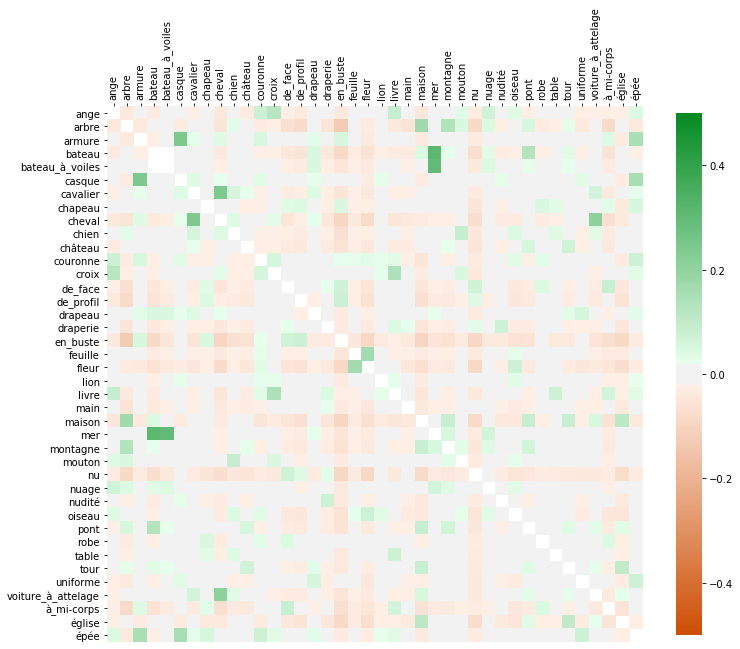

In [65]:
fig=plt.figure(figsize=(12, 12))

cmap_div = sns.diverging_palette(22, 130, s=99, n=16, as_cmap=True)

mask = corr_df >= 0.5

ax = sns.heatmap(corr_df , cmap=cmap_div,
                 mask = mask,
                 vmin=-0.5, vmax=0.5 , center =0.0,
                 square=True, cbar_kws={"shrink": 0.8})

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_ticks_position('top')

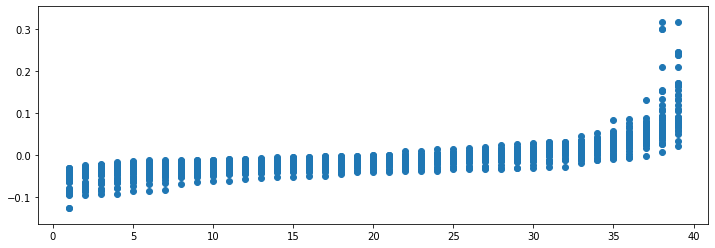

In [541]:
fig=plt.figure(figsize=(12, 4))

plt.scatter(x = corr_df[corr_df < 0.5].rank(),
            y = corr_df[corr_df < 0.5])

In [98]:
top_corr_df = corr_df.stack().reset_index()
top_corr_df.columns = ['label_A', 'label_B', 'cor']

top_corr_df = top_corr_df[(top_corr_df.cor > 0.1) & (top_corr_df.cor < 0.5)]

print(top_corr_df.shape)
top_corr_df.sort_values(by='cor', ascending=False)

(30, 3)


,label_A,label_B,cor
144,bateau,mer,0.316174
963,mer,bateau,0.316174
964,mer,bateau_à_voiles,0.298644
184,bateau_à_voiles,mer,0.298644
85,armure,casque,0.244525
202,casque,armure,0.244525
248,cavalier,cheval,0.238332
326,cheval,cavalier,0.238332
1448,voiture_à_attelage,cheval,0.208009
356,cheval,voiture_à_attelage,0.208009


In [890]:
label_A = 'bateau'#'cheval'#, 'mer'
label_B = 'mer' #'voiture à attelage'#'bateau'

label_A_ = label_A.replace(' ', '_')
label_B_ = label_B.replace(' ', '_')

In [891]:
from collections import namedtuple
Label_Stats = namedtuple('Label_Stats', ['Probs', 'Joint_prob', 'Cond_probs', 
                                         'Variance', 'Odds', 
                                         'Covariance', 'Correlation', 
                                         'PWOR'])

def calculate_stats (df, label_A, label_B, prnt=False):

    p_A = df[label_A].sum() / df.shape[0]
    p_B = df[label_B].sum() / df.shape[0]
    p_AB = (df[[label_A, label_B]].sum(axis=1) == 2).sum() / df.shape[0]
    p_A_given_B = p_AB / p_B
    p_B_given_A = p_AB / p_A

    var_A = p_A * (1-p_A)
    var_B = p_B * (1-p_B)

    odds_A = p_A /(1 - p_A)
    odds_B = p_B /(1 - p_B)

    cov_AB = p_AB - p_A*p_B
    cor_AB = cov_AB / ( np.sqrt(var_A) * np.sqrt(var_B) )
    
    pwor_AB = odds_A * ((1 - p_B_given_A) / p_B_given_A)
    pwor_BA = odds_B * ((1 - p_A_given_B) / p_A_given_B)
    
 
    if (prnt):

        print('count(%s) = %d' % ( label_A, df[label_A].sum()) )
        print('count(%s) = %d' % ( label_B, df[label_B].sum()) )
        print()
        print('P(%s) = %f' % (label_A, p_A))
        print('P(%s) = %f' % (label_B, p_B))
        print('P(%s,%s) = %f' % (label_A, label_B, p_AB))
        print()
        print('P(%s|%s) = %f' % (label_A, label_B, p_A_given_B))
        print('P(%s|%s) = %f' % (label_B, label_A, p_B_given_A))
        print()
        print('Odds(%s) = %f' % (label_A, odds_A))
        print('Odds(%s) = %f' % (label_B, odds_B))
        print()
        print('Var(%s) = %f' % (label_A, var_A))
        print('Var(%s) = %f' % (label_B, var_B))
        print()
        print('Cov(%s,%s) = %f' % (label_A, label_B, cov_AB))
        print()
        print('Cor(%s,%s) = %f' % (label_A, label_B, cor_AB))
        print()
        print('PWOR(%s|%s) = %f' % (label_A, label_B, pwor_AB))        
        print('PWOR(%s|%s) = %f' % (label_B, label_A, pwor_BA))        
        

    stats = Label_Stats( (p_A, p_B), p_AB, (p_A_given_B, p_B_given_A), (var_A, var_B), (odds_A, odds_B), cov_AB, cor_AB,
                        (pwor_AB, pwor_BA))
    return stats

stats = calculate_stats(annotations_df, label_A_, label_B_, prnt=True)

count(bateau) = 5787
count(mer) = 2317

P(bateau) = 0.059374
P(mer) = 0.023772
P(bateau,mer) = 0.012794

P(bateau|mer) = 0.538196
P(mer|bateau) = 0.215483

Odds(bateau) = 0.063122
Odds(mer) = 0.024351

Var(bateau) = 0.055849
Var(mer) = 0.023207

Cov(bateau,mer) = 0.011383

Cor(bateau,mer) = 0.316174

PWOR(bateau|mer) = 0.229810
PWOR(mer|bateau) = 0.020895


In [892]:
formula = '%s ~ %s' % (label_A_, label_B_)

res = sm.formula.glm(formula,  family=sm.families.Binomial(), data=annotations_df).fit() 
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 bateau   No. Observations:                97467
Model:                            GLM   Df Residuals:                    97465
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19842.
Date:                Thu, 13 Aug 2020   Deviance:                       39685.
Time:                        16:29:52   Pearson chi2:                 9.75e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9936      0.015   -196.839      0.0

In [893]:
query_image_for_category_pair_swith_scores = '''
prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix skos: <http://www.w3.org/2004/02/skos/core#> 
prefix jcl: <http://jocondelab.iri-research.org/ns/jocondelab/>
#prefix dc: <http://purl.org/dc/elements/1.1/> 
prefix ml: <http://ns.inria.fr/monalia/>

select ?ref
       ?imageURL
       ?title
       ?repr
       ?target_labels
       ?actual_labels
       ?classifier_label
       ?score
       
where 
{

    {
        select  ?notice
                (group_concat(distinct ?topCategory_label; separator="+") as ?target_labels)
                (group_concat(distinct ?subCategory_label;  separator="+") as ?actual_labels)

        where { 

               VALUES (?topCategory_label) { ("%s"@fr) ("%s"@fr) } 
               
                ?topCategory a jcl:Term;
                       skos:prefLabel ?topCategory_label;
                       skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>;
                       skos:narrower* ?subCategory.

                ?subCategory  skos:prefLabel ?subCategory_label.

                ?notice jcl:noticeReprTerm ?subCategory;
                        jcl:noticeHasImage true;   
                
        }
        group by ?notice 
        #limit 10
    }
    
    ?notice jcl:noticeRef ?ref;
            jcl:noticeImage [ jcl:noticeImageIsMain true ; jcl:noticeImageUrl ?imageURL].        

    optional {?notice jcl:noticeTitr  ?title.}
    optional {?notice jcl:noticeRepr  ?repr.}
     
    
    {
       select *
       where {
       
        VALUES (?classifier_label) { ("%s"@fr) ("%s"@fr) }  
    
        ?classifierCategory a jcl:Term;
                    skos:prefLabel ?classifier_label;
                    skos:inScheme <http://data.culture.fr/thesaurus/resource/ark:/67717/T523>.
        
        ?classifier rdfs:label "40_classes".

        ?notice ml:imageClassifier [a ?classifier ;
                                    ml:detected [ a ?classifierCategory ;
                                                  ml:score ?score ]].

    }
   }
}

''' % (label_A, label_B, label_A, label_B )

In [894]:
%time test_df = metadata.sparql_service_to_dataframe(wds_Joconde_Corese, query_image_for_category_pair_swith_scores)
print(test_df.shape)

Wall time: 20 s
(12160, 8)


In [899]:
def agg_scores(x):
    _x = x#.sort_values(by='classifier_label' , ascending=True, inplace=False) 

    return pd.Series(dict(#targets = _x.iloc[0].target_labels,
                          pred_dict = dict(zip(_x['classifier_label'], _x['score'].astype(float))) 
                          #predictions = list(_x['classifier_label']),
                          #scores = list(_x['score'])
                         ))

def adjust_scores(logit_res, score_A, score_B, base_prob_B = 0.5 ):
    odds_pred_A = score_A / (1-score_A)
    
    pwor_A_given_B = np.exp(logit_res.params[1] * (score_B - base_prob_B))
    
    odds_pred_A_new = odds_pred_A * pwor_A_given_B
    
    score_A_new = odds_pred_A_new / (1+ odds_pred_A_new)
    
    return score_A_new

def adjust_scores_with_th(logit_res, score_A, score_B, base_prob_B = 0.5, th=0.5 ):
    odds_pred_A = score_A / (1-score_A)
    if (score_B > th): 
        pwor_A_given_B = np.exp(logit_res.params[1] * (score_B - base_prob_B))

        odds_pred_A_new = odds_pred_A * pwor_A_given_B

        score_A_new = odds_pred_A_new / (1+ odds_pred_A_new)
    else:
        score_A_new = score_A
    
    return score_A_new


test_df_ = test_df.groupby('ref') \
                   .apply(agg_scores) \
                   .reset_index() \
                   .set_index('ref')

test_df_['adjusted_score_A'] = test_df_.apply(lambda x: adjust_scores(res,
                                                                      x.pred_dict[label_A],
                                                                      x.pred_dict[label_B],
                                                                       base_prob_B=0.023), axis=1 )
test_df_  = test_df_.merge(annotations_df.set_index('noticeReference').loc[:, [label_A_, label_B_]] ,
                           left_index=True,
                           right_index=True) 

test_df_.head()


,pred_dict,adjusted_score_A,bateau,mer
00000055089,"{'bateau': 0.9991, 'mer': 0.9879}",1.0000,1,1
00000055228,"{'bateau': 0.3772, 'mer': 0.5096}",0.7369,0,1
00000055403,"{'bateau': 0.9967, 'mer': 0.9446}",0.9998,1,0
00000055404,"{'bateau': 0.8668, 'mer': 0.1874}",0.9161,1,0
00000055528,"{'bateau': 0.4962, 'mer': 0.9357}",0.9457,1,1


In [900]:
y_true = np.array(test_df_.loc[:, [label_A_, label_B_]] , dtype = np.dtype('B')) 
y_scores =  pd.DataFrame.from_dict({label_A: test_df_.pred_dict.apply(lambda x: x[label_A]),
                                    label_B: test_df_.pred_dict.apply(lambda x: x[label_B])}).to_numpy()

AP =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores,
                                      average= None)
print('original AP', dict(zip([label_A, label_B], AP)))



y_scores_adj =  pd.DataFrame.from_dict({label_A: test_df_.adjusted_score_A,
                                    label_B: test_df_.pred_dict.apply(lambda x: x[label_B])}).to_numpy()


AP_adj =  metrics.average_precision_score(y_true= y_true,
                                      y_score=y_scores_adj,
                                      average= None)
print('adjusted AP', dict(zip([label_A, label_B], AP_adj)))

original AP {'bateau': 0.947697375133173, 'mer': 0.6243326734752279}
adjusted AP {'bateau': 0.9285504569098353, 'mer': 0.6243326734752279}


Text(0.5, 1.0, ' Precision-Recall curve: mer AP=0.62')

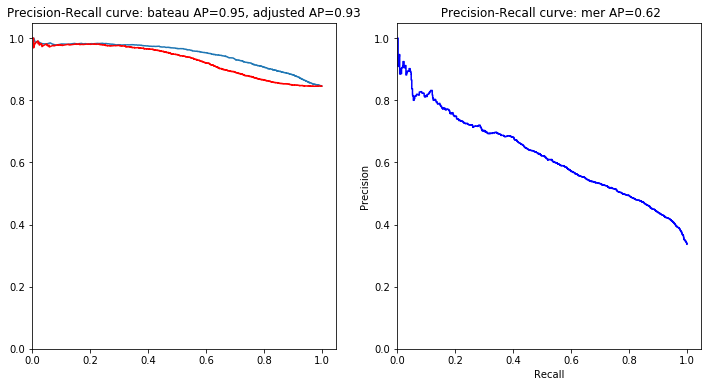

In [901]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches((12,6))

precision_A, recall_A, th = metrics.precision_recall_curve(y_true[:, 0],
                                                          y_scores[:, 0])

ax1.plot(recall_A, precision_A)

precision_A_adj, recall_A_adj, _ = metrics.precision_recall_curve(y_true[:, 0],
                                                          y_scores_adj[:, 0])

ax1.plot(recall_A_adj, precision_A_adj, color='red')
ax1.set_xlim(0.0, 1.05)
ax1.set_ylim(0.0, 1.05)
ax1.set_title('Precision-Recall curve: {0} AP={1:0.2f}, adjusted AP={2:0.2f}'.format(label_A, AP[0], AP_adj[0]))

precision_B, recall_B, _ = metrics.precision_recall_curve(y_true[:, 1],
                                                          y_scores[:, 1])

ax2.step(recall_B, precision_B, color='b', where='post')
#ax2.fill_between(recall_B, precision_B, alpha=0.2, color='b', step='post')
ax2.set_xlim(0.0, 1.05)
ax2.set_ylim(0.0, 1.05)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(' Precision-Recall curve: {0} AP={1:0.2f}'.format(label_B, AP[1]))

In [902]:
threshold_A = 0.85
threshold_B = 0.9

y_pred = (y_scores > np.array([threshold_A, threshold_B])).astype(dtype = np.dtype('B'))

report = metrics.classification_report(y_true= y_true,
                                         y_pred= y_pred, 
                                         target_names = [label_A, label_B])

print(report)

print()

y_pred_adj = (y_scores_adj > np.array([threshold_A, threshold_B])).astype(dtype = np.dtype('B'))

report_adj = metrics.classification_report(y_true= y_true,
                                         y_pred= y_pred_adj, 
                                         target_names = [label_A, label_B])

print(report_adj)

              precision    recall  f1-score   support

      bateau       0.92      0.77      0.83      5141
         mer       0.53      0.71      0.61      2038

   micro avg       0.76      0.75      0.76      7179
   macro avg       0.72      0.74      0.72      7179
weighted avg       0.80      0.75      0.77      7179
 samples avg       0.62      0.73      0.65      7179


              precision    recall  f1-score   support

      bateau       0.85      0.89      0.87      5141
         mer       0.53      0.71      0.61      2038

   micro avg       0.74      0.84      0.79      7179
   macro avg       0.69      0.80      0.74      7179
weighted avg       0.76      0.84      0.79      7179
 samples avg       0.69      0.83      0.73      7179



C:\Users\abobashe\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [796]:
def gather_row_annotation(row):
    return '\n'.join( wrap(row.title, 30 ) + 
                     [''] + 
                    wrap(row.repr, 30 ) +
                    ['',
                     '<a target="_blank" href="https://www.pop.culture.gouv.fr/notice/joconde/%s">%s</a>' % (row.ref, row.ref),
                     #'',
                    # row.imagePath
                    ])

def aggregate_group_by(x):
    _x = x#.sort_values(by='classifier_label' , ascending=True, inplace=False) 

    return pd.Series(dict(imageURL = _x.iloc[0].imageURL, 
                          info = gather_row_annotation(_x.iloc[0]), 
                          actuals=  _x.iloc[0]['actual_labels'].replace('+', '\n'),
                          targets=  _x.iloc[0]['target_labels'].replace('+', '\n'),
                          predictions = '\n'.join(_x['classifier_label']),
                          scores = '\n'.join(_x['score'])
                         ))

formatters_dict={'imageURL': vis_helpers.image_url_formatter,
                 'info': vis_helpers.label_formatter, 
                 'repr': vis_helpers.repr_formatter,
                 'predictions': vis_helpers.label_formatter,
                 'classifier_label':  vis_helpers.label_formatter,
                 'scores':  vis_helpers.label_formatter,
                 'actuals':  vis_helpers.label_formatter,
                 'targets':  vis_helpers.label_formatter}


In [811]:
pd.set_option('display.max_colwidth', None)
pd.set_option('colheader_justify', 'center') 
pd.set_option('precision', 4)

test_df.fillna('', inplace=True)

print(test_df.groupby('ref').size().shape)
HTML(test_df.groupby('ref') \
                   .apply(aggregate_group_by) \
                   .reset_index() \
                   .set_index('ref')[:20] \
                   .merge(test_df_.loc[:, ['adjusted_score_A']], left_index=True, right_index=True) \
                   .to_html( 
                        formatters=formatters_dict, 
                        escape=False,
                        index=False))

(7964,)


imageURL,info,actuals,targets,predictions,scores,adjusted_score_A
,"LA CARAVANE.DIT AUSSI LECONVOIscène (charrette, cavalier,cheval, homme : habit, couvre-chef, Cosaque, moyen detransport par route : cuir)00000055064",chevalcharrette,chevalvoiture à attelage,chevalvoiture à attelage,0.95740.9749,0.9853
,"ETUDE ALGERIENNE ; DIT AUSSISCENE ARABEgroupe de figures (homme,cheval, rue, arcade, habit,Algérie)00000055088",cheval,cheval,chevalvoiture à attelage,0.58440.6493,0.5844
,"Mort du général Kirgenerscène historique (KirgenerFrançois Joseph, Planta baronde, cadavre, général,officier, cheval)00000055160",cheval,cheval,chevalvoiture à attelage,0.9260.4964,0.9260
,"La Bénédiction ""urbi et orbi""scène (bénédiction, Rome,place, église, foule, voitureà attelage, Grégoire XVI,Ingres Jean Auguste Dominique,Ingres Madeleine)00000055172",voiture à attelage,voiture à attelage,chevalvoiture à attelage,0.89910.9485,0.9616
,"Etude de chevalreprésentation animalière(cheval, lien)00000055176",cheval,cheval,chevalvoiture à attelage,0.94980.0871,0.9498
,"La Vengeance de Médéescène mythologique (Médée,Jason, enfant, cadavre,meurtre, mort par le fer,épée, cadavre, char, dragon,serpent)00000055201",char,voiture à attelage,chevalvoiture à attelage,0.8410.9244,0.9337
,"FETE DANS LES JARDINS DU DUCDE MANTOUEscène (groupe, fête, jardin,fontaine, ronde bosse,vêtement, luths, époqueRenaissance, Italie) ; vued'architecture (palais,loggia, carrosse, jeud'adresse)00000055394",carrosse,voiture à attelage,chevalvoiture à attelage,0.83630.9127,0.9298
,"Rue de New-York en 1840 ; Ruede Broadway (New-York) (autretitre) ; New-York sous laneige (autre titre)vue d'architecture (rue, NewYork, neige) ; groupe defigures (foule, pompier :charrette, traîneau :manifestation, époque Louis-Philippe)00000055419",charrette,voiture à attelage,chevalvoiture à attelage,0.83540.9682,0.9373
,"LA POURVOYEUSE DE MISEREgroupe de figures (jeunefille, vieille, pauvreté,allégorie : chasteté : letravail, voiture découverte,ville : symbole : vice,nudité)00000055456",voiture découverte,voiture à attelage,chevalvoiture à attelage,0.59290.9162,0.7918
,"MARCHE EN KABYLIE ; DIT AUSSIEN MARCHE ARABE EN ALGERIEscène (foule, arabe, marché,tente, cheval, âne, feuillu,désert, Algérie)00000055475",cheval,cheval,chevalvoiture à attelage,0.84190.9109,0.9322


# Scrapbook

In [414]:
import statsmodels.api as sm

res = sm.formula.glm("mer ~ bateau",  family=sm.families.Binomial(), 
                     data=annotations_df).fit() 
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mer   No. Observations:                97467
Model:                            GLM   Df Residuals:                    97465
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8841.7
Date:                Tue, 11 Aug 2020   Deviance:                       17683.
Time:                        15:56:43   Pearson chi2:                 9.75e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4389      0.031   -144.351      0.0

In [396]:
print("Coefficeients")
print(res.params)
print()
print("p-Values")
print(res.pvalues)
print()
print("Dependent variables")
print(res.model.endog_names)

Coefficeients
Intercept   -4.438906
bateau       3.146720
dtype: float64

p-Values
Intercept    0.0
bateau       0.0
dtype: float64

Dependent variables
mer


In [769]:
odds_pred_mer_new = odds_pred_mer * pwor_mer_given_bateau
print(odds_pred_mer_new)
p_mer_new = odds_pred_mer_new / (1+ odds_pred_mer_new)
print(p_mer_new)

2.9205266109943206
0.7449322248710918


In [399]:
x = pd.DataFrame.from_dict({'bateau': [0.0, 0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]})

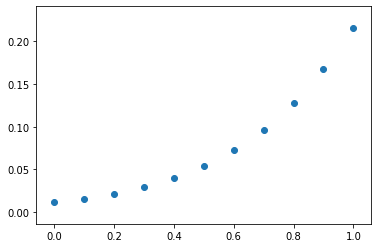

In [400]:
res_pred = pd.Series(res.predict(x, transform=True)) #.apply(lambda s: 1 / (1+ np.exp(-s)))
plt.scatter(x = x,
            y = res_pred)

In [404]:
res_pred

0     0.011671
1     0.015918
2     0.021678
3     0.029458
4     0.039917
5     0.053883
6     0.072368
7     0.096546
8     0.127691
9     0.167025
10    0.215483
dtype: float64

In [402]:
odds_mer_if_bateau = np.exp(res.params[0] + res.params[1])
print(odds_mer_if_bateau)
p_mer = odds_mer_if_bateau / (odds_mer_if_bateau + 1)
print(p_mer)


0.27466960352420006
0.21548297909104833


In [544]:
#P(mer) = 0.023772
#P(bateau) = 0.059374
#P(mer,bateau) = 0.012794

#P(mer|bateau) = 0.215483
#P(bateau|mer) = 0.538196

ps_mer = 0.1874#0.5096#0.1874 
ps_bateau = 0.8668#0.3772#0.8668

odds_pred_mer = ps_mer / (1-ps_mer)
odds_pred_mer

0.23061777012060056

In [547]:
#pwor_mer_given_bateau = np.exp(-4.4389 + 3.1467 * ps_bateau)
pwor_mer_given_bateau = np.exp(3.1467 * (ps_bateau-0.06))
pwor_mer_given_bateau

12.663927022913473